# Part 3: ECG Analysis

## Introduction

In this part, you'll work with the MIT-BIH Arrhythmia Database to build a model for heartbeat classification using a simple neural network architecture. This will help you understand how to apply neural networks to time series data in healthcare.

## Learning Objectives

- Load and preprocess ECG time series data
- Implement a simple neural network for sequence classification
- Train and evaluate the model
- Interpret results in a clinical context

## Setup and Installation

In [ ]:
# Install required packages
# %pip install -r requirements.txt
%pip install wfdb  # For reading MIT-BIH format

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Flatten, Dense, BatchNormalization, Dropout, Conv1D, MaxPooling1D, LeakyReLU, GlobalAveragePooling1D
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wfdb
from scipy import signal
import urllib.request
import zipfile

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_3', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Download MIT-BIH dataset
data_dir = 'data/mit-bih-arrhythmia-database-1.0.0'
if not os.path.exists(data_dir):
    print("Downloading MIT-BIH Arrhythmia Database...")
    url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    zip_path = 'data/mitdb.zip'
    
    # Download dataset
    urllib.request.urlretrieve(url, zip_path)
    
    # Extract dataset
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    # Clean up
    os.remove(zip_path)
    print("Dataset downloaded and extracted successfully.")

## 1. Data Loading and Preprocessing

Signal shape: (650000, 2)
Number of annotations: 2274
Unique beat types: ['+' 'A' 'N' 'V']


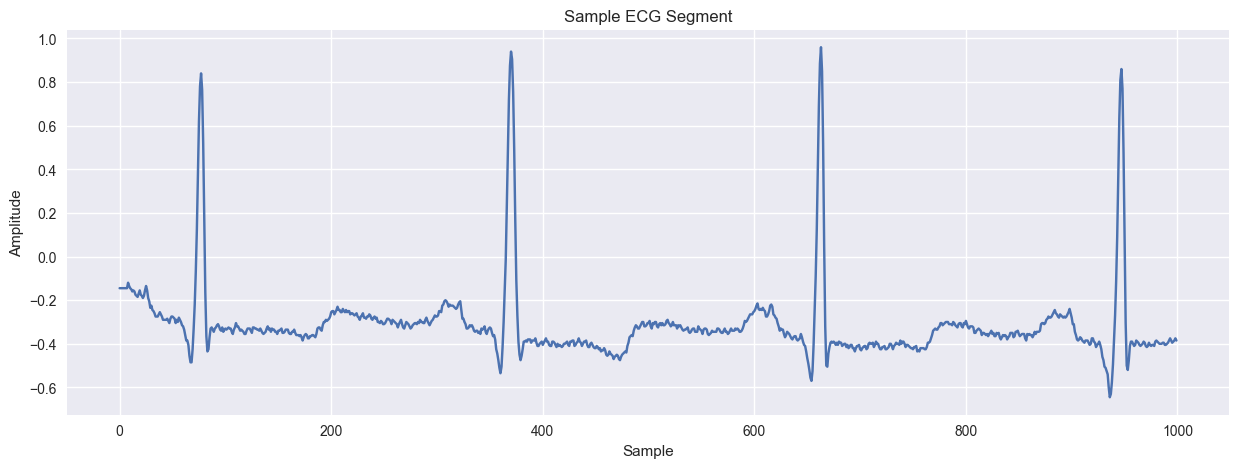

In [105]:
# Load ECG data
record_path = 'data/mit-bih-arrhythmia-database-1.0.0/100'  # Example record
record = wfdb.rdrecord(record_path)
signals = record.p_signal

# Read annotations
ann = wfdb.rdann(record_path, 'atr')
annotations = ann.symbol

# Print data information
print(f"Signal shape: {signals.shape}")
print(f"Number of annotations: {len(annotations)}")
print(f"Unique beat types: {np.unique(annotations)}")

# Plot sample ECG segment
plt.figure(figsize=(15, 5))
plt.plot(signals[:1000, 0])
plt.title('Sample ECG Segment')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Data shape: (2273, 180, 2)
Label distribution: [2239   34]


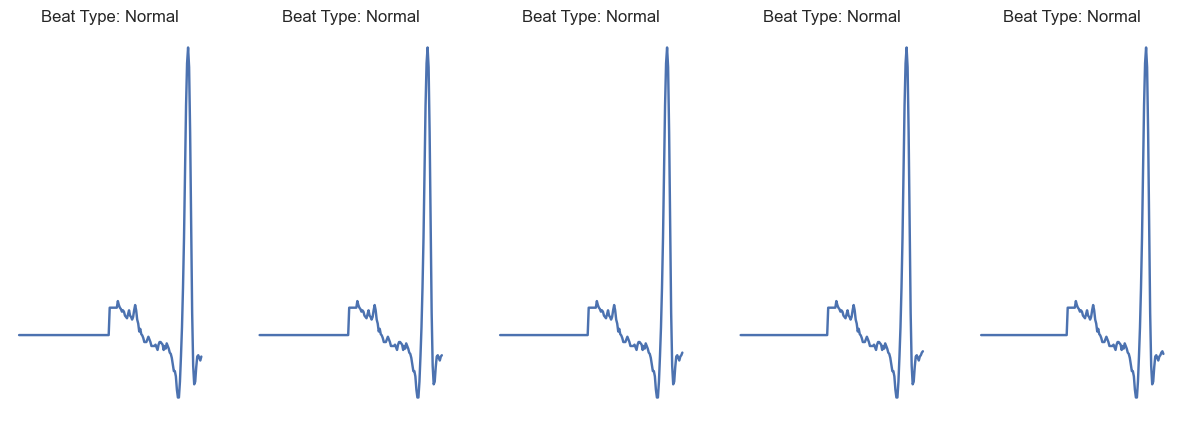

In [106]:
# Preprocess ECG data
window_size = 180

# Normalize signals
signals = (signals - np.mean(signals)) / np.std(signals)

# Extract beats
X = []
y = []

for i, ann in enumerate(annotations):
    if ann in ['N', 'L', 'R', 'A', 'V']:  # Normal and abnormal beats
        # Get window around beat
        start = max(0, i - window_size//2)
        end = min(len(signals), i + window_size//2)
        
        # Pad if necessary
        if start == 0:
            pad_left = window_size//2 - i
            segment = np.pad(signals[start:end], ((pad_left, 0), (0, 0)))
        elif end == len(signals):
            pad_right = window_size//2 - (len(signals) - i)
            segment = np.pad(signals[start:end], ((0, pad_right), (0, 0)))
        else:
            segment = signals[start:end]
        
        X.append(segment)
        
        # Convert annotation to label
        if ann == 'N':
            y.append(0)  # Normal
        else:
            y.append(1)  # Abnormal

X = np.array(X)
y = np.array(y)

print(f"Data shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")

# Plot sample beats
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(X[i, :, 0])
    plt.title(f'Beat Type: {"Normal" if y[i] == 0 else "Abnormal"}')
    plt.axis('off')
plt.show()

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 2. Model Implementation

In [107]:
# Create simple neural network
def create_simple_nn(input_shape):
    """
    Create a simple neural network for ECG classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use binary crossentropy loss
    - Must include AUC metric
    
    Goals:
    - Achieve > 75% accuracy on test set
    - Achieve AUC > 0.80
    - Achieve F1-score > 0.70
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (180, 2) for ECG windows)
    
    Returns:
        Compiled Keras model
    """
    model = Sequential([

        InputLayer(shape=input_shape),

        Conv1D(32, kernel_size=5, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2), 
        Dropout(0.2),
        
        Conv1D(64, kernel_size=5, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Flatten(),

        Dense(128),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
        ]
    )
    
    return model

# Create and compile model
model = create_simple_nn(input_shape=(180, 2))
model.summary()

/Users/sarahli/anaconda3/envs/sarahli/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_39 (Conv1D)              │ (None, 180, 32)        │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 180, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 180, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 90, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 90, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 90, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 90, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 128)            │       368,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,897 (1.48 MB)

 Trainable params: 388,321 (1.48 MB)

 Non-trainable params: 576 (2.25 KB)

## 3. Training and Evaluation

Epoch 1/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4849 - auc: 0.5249 - loss: 0.8989 - precision: 0.0140 - recall: 0.4761 - val_accuracy: 0.1566 - val_auc: 0.2203 - val_loss: 0.8267 - val_precision: 0.0033 - val_recall: 0.5000 - learning_rate: 5.0000e-04
Epoch 2/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4640 - auc: 0.5101 - loss: 0.8535 - precision: 0.0169 - recall: 0.5974 - val_accuracy: 0.0412 - val_auc: 0.2431 - val_loss: 0.9475 - val_precision: 0.0057 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4787 - auc: 0.5116 - loss: 0.9007 - precision: 0.0167 - recall: 0.6251 - val_accuracy: 0.2885 - val_auc: 0.2825 - val_loss: 0.8672 - val_precision: 0.0039 - val_recall: 0.5000 - learning_rate: 5.0000e-04
Epoch 4/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4850 - auc: 0.6938 - loss: 0.6773 - precision: 0.0235 - recall: 0.8555 - val_accuracy: 0.1374 - val_auc: 0.3405 - val_loss: 0.9686 

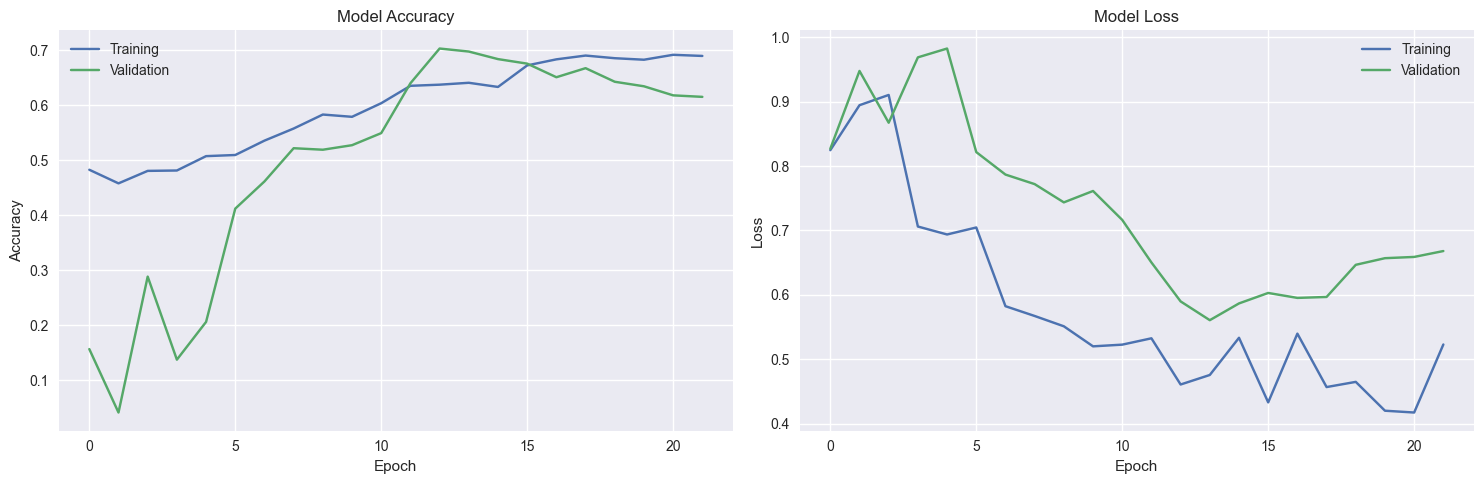

In [108]:
# Consider class weights

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

#  Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/ecg_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6834 - auc: 0.4544 - loss: 0.5896 - precision: 0.0107 - recall: 0.1278         
Test accuracy: 0.6791
Test AUC: 0.5531
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


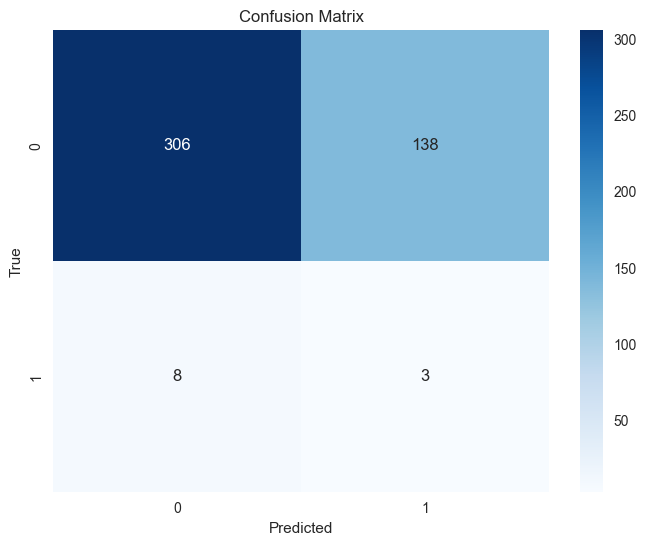

In [109]:
# Evaluate model
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Get predictions
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.numpy().ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

# Save metrics
metrics = {
    'model': 'ecg_classifier',
    'accuracy': float(test_accuracy),
    'auc': float(test_auc),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_3/ecg_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"auc: {metrics['auc']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")

In [110]:
print(np.sum(y_train == 0))
print(np.sum(y_train == 1))


1433
21


## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully download MIT-BIH dataset
   - [ ] Load and visualize ECG signals
   - [ ] Verify signal shape and annotations

2. **Preprocessing**:
   - [ ] Normalize signals
   - [ ] Extract beat windows
   - [ ] Verify window shapes and labels

3. **Model Implementation**:
   - [ ] Create simple neural network
   - [ ] Verify model architecture
   - [ ] Test model output shape

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: MIT-BIH dataset not found
   - Solution: Check internet connection and wfdb installation

2. **Preprocessing Issues**:
   - Problem: Signal normalization errors
   - Solution: Check signal statistics and normalization method
   - Problem: Window extraction errors
   - Solution: Verify window size and padding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters